In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import hvplot.pandas
from pathlib import Path
from pandas_datareader import DataReader
import pandas_datareader.data as web
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import quandl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

%matplotlib inline

In [16]:
# Setting dates
start = datetime.datetime(2014, 12, 1)
end = datetime.datetime.now()

In [3]:
# importing TSLA / BABA / AMD / SQ
amd_df = DataReader('AMD', 'yahoo', start, end)
amd_close = amd_df[['Close', 'Volume']]
amd_close.columns = ['AMD_Close', 'AMD_Volume']
amd_close.head(5)

,AMD_Close,AMD_Volume
Date,,
2014-12-01,2.67,16025100
2014-12-02,2.68,12438800
2014-12-03,2.74,18256500
2014-12-04,2.69,14513400
2014-12-05,2.66,9479300


In [4]:
mu_df = DataReader('MU', 'yahoo', start, end)
mu_close = mu_df[['Close', 'Volume']]
mu_close.columns = ['MU_Close', 'MU_Volume']
mu_close.head(5)

,MU_Close,MU_Volume
Date,,
2014-12-01,34.990002,21342300
2014-12-02,35.599998,14281500
2014-12-03,36.099998,29011500
2014-12-04,36.070000,16477600
2014-12-05,36.490002,14114800


In [5]:
nvda_df = DataReader('NVDA', 'yahoo', start, end)
nvda_close = nvda_df[['Close', 'Volume']]
nvda_close.columns = ['NVDA_Close', 'NVDA_Volume']
nvda_close.head(5)

,NVDA_Close,NVDA_Volume
Date,,
2014-12-01,20.580000,4751500.0
2014-12-02,20.610001,6148800.0
2014-12-03,21.139999,7110600.0
2014-12-04,20.950001,4633300.0
2014-12-05,21.070000,4142000.0


In [6]:
intc_df = DataReader('INTC', 'yahoo', start, end)
intc_close = intc_df[['Close', 'Volume']]
intc_close.columns = ['INTC_Close', 'INTC_Volume']
intc_close.head(5)

,INTC_Close,INTC_Volume
Date,,
2014-12-01,37.169998,30904000.0
2014-12-02,37.599998,28361100.0
2014-12-03,37.430000,30660800.0
2014-12-04,37.459999,23359100.0
2014-12-05,37.669998,20527600.0


# Features

In [18]:
ALPHA_VANTAGE_API_KEY = '9AO3LVVFPEXPZ5KI'

# ADI (Analog Devices / Semiconductor-Integrated circuits)
adi_df = DataReader('ADI', 'yahoo', start, end)
adi_close = adi_df[['Close', 'Volume']]
adi_close.columns = ['ADI_Close', 'ADI_Volume']

# XLNX (Xilixn.Inc / Supplier of programmable logic devices)
xlnx_df = DataReader('XLNX', 'yahoo', start, end)
xlnx_close = xlnx_df[['Close', 'Volume']]
xlnx_close.columns = ['QQQ_Close', 'QQQ_Volume']

# MCHI
mchi_df = DataReader('MCHI', 'yahoo', start, end)
mchi_close = mchi_df[['Close', 'Volume']]
mchi_close.columns = ['MCHI_Close', 'MCHI_Volume']

# AMAT (Applied Materials)
amat_df = DataReader('AMAT', 'yahoo', start, end)
amat_close = amat_df[['Close', 'Volume']]
amat_close.columns = ['AMAT_Close', 'AMAT_Volume']

# TER (Semiconductor testing system)
ter_df = DataReader('TER', 'yahoo', start, end)
ter_close = ter_df[['Close', 'Volume']]
ter_close.columns = ['TER_Close', 'TER_Volume']

# FCX (Mining and Exploration company)
fcx_df = DataReader('FCX', 'yahoo', start, end)
fcx_close = fcx_df[['Close', 'Volume']]
fcx_close.columns = ['FCX_Close', 'FCX_Volume']


In [19]:
# Concatenating each stock
stocks_df = pd.concat([amd_close, mu_close, nvda_close, intc_close, adi_close, xlnx_close, mchi_close, amat_close, ter_close, fcx_close], axis=1, join='outer')
stocks_df.isnull().sum()

AMD_Close      0
AMD_Volume     0
MU_Close       0
MU_Volume      0
NVDA_Close     0
NVDA_Volume    0
INTC_Close     0
INTC_Volume    0
ADI_Close      0
ADI_Volume     0
QQQ_Close      0
QQQ_Volume     0
MCHI_Close     0
MCHI_Volume    0
AMAT_Close     0
AMAT_Volume    0
TER_Close      0
TER_Volume     0
FCX_Close      0
FCX_Volume     0
dtype: int64

# Correlation 

In [20]:
import seaborn as sns
daily_returns = stocks_df.pct_change()
daily_returns = daily_returns.dropna()
daily_returns.head()

,AMD_Close,AMD_Volume,MU_Close,MU_Volume,NVDA_Close,NVDA_Volume,INTC_Close,INTC_Volume,ADI_Close,ADI_Volume,QQQ_Close,QQQ_Volume,MCHI_Close,MCHI_Volume,AMAT_Close,AMAT_Volume,TER_Close,TER_Volume,FCX_Close,FCX_Volume
Date,,,,,,,,,,,,,,,,,,,,
2014-12-02,0.003745,-0.223793,0.017433,-0.330836,0.001458,0.294076,0.011568,-0.082284,0.010247,-0.114151,0.011482,-0.327508,0.020610,-0.256006,0.005476,0.031664,0.007132,-0.302499,-0.012595,-0.190624
2014-12-03,0.022388,0.467706,0.014045,1.031404,0.025716,0.156421,-0.004521,0.081086,0.023546,1.888370,0.022702,2.159968,-0.005856,0.500347,0.030163,0.650672,0.022256,1.109671,0.032083,-0.143914
2014-12-04,-0.018248,-0.205028,-0.000831,-0.432032,-0.008988,-0.348395,0.000801,-0.238144,0.001947,-0.502221,0.001281,-0.278893,0.023766,-0.250174,-0.007727,-0.419311,-0.010391,-0.269889,-0.010112,-0.404339
2014-12-05,-0.011152,-0.346859,0.011644,-0.143395,0.005728,-0.106037,0.005606,-0.121216,0.012716,-0.277641,0.005329,-0.469648,0.009722,-0.138580,0.026230,0.899228,0.009000,-0.337693,-0.015891,0.137600
2014-12-08,-0.030075,1.679744,-0.012880,0.120476,-0.012814,0.369773,-0.012477,0.370584,-0.020230,-0.062831,-0.005513,0.512593,-0.010218,0.184880,-0.031949,-0.030833,-0.020317,0.255624,-0.033833,0.491707


In [21]:
correlation = daily_returns.corr()

AMD_Close     0.434165
MU_Close      0.499685
NVDA_Close    1.000000
INTC_Close    0.481463
ADI_Close     0.527520
QQQ_Close     0.482589
MCHI_Close    0.423421
AMAT_Close    0.535859
TER_Close     0.477862
FCX_Close     0.216712
Name: NVDA_Close, dtype: float64

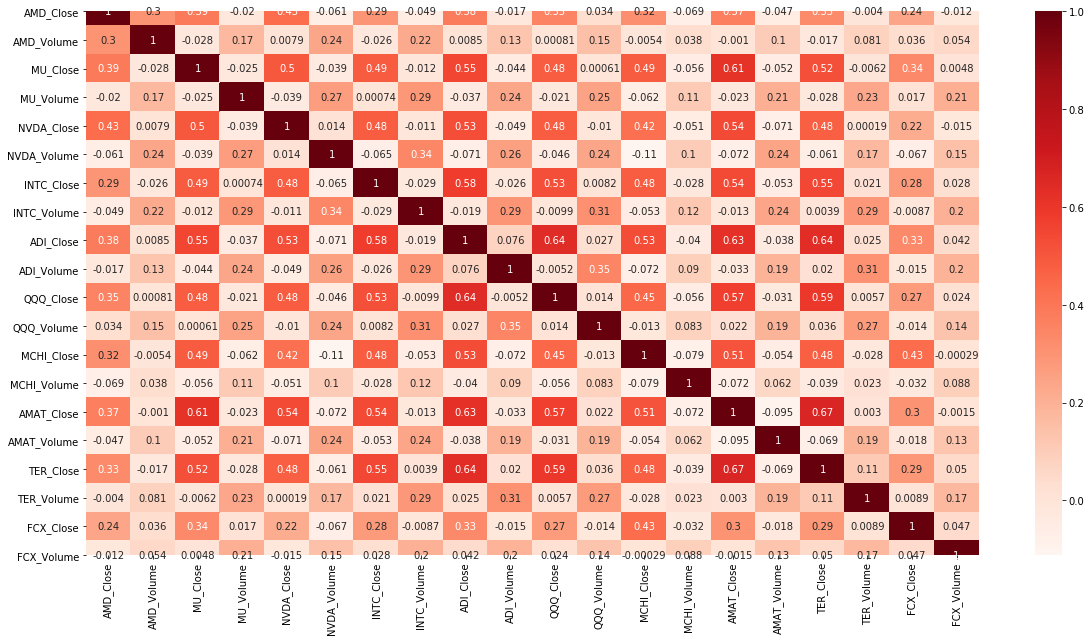

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
cor_target = abs(correlation['NVDA_Close'])

#Selecting highly correlated features
re_features = cor_target[cor_target>0.1]
re_features

In [31]:
features_daily_return = features_df.diff()
features_daily_return = features_daily_return.dropna()
correlation_features = features_daily_return.corr()

NameError: name 'features_df' is not defined

# Volatility

In [ ]:
#Augmented Dickey-Fuller test to determine if the stocks are stationary
from statsmodels.tsa.stattools import adfuller
adfuller(stocks_df.BABA_Close)

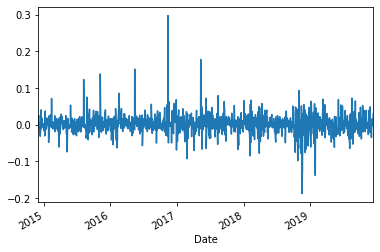

In [32]:
# Making stationary
df = stocks_df.copy()
df['Returns_NVDA'] = df.NVDA_Close.pct_change()
df = df.dropna()
returns_nvda = df.loc[:, 'Returns_NVDA']
returns_nvda.plot()

In [33]:
# GARCH
import arch as arch
from arch import arch_model

In [34]:
model_nvda = arch_model(returns_nvda, mean='Zero', vol='GARCH', p=2, q=2)
final_nvda = model_nvda.fit(disp='off')
final_nvda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           Returns_NVDA   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2820.39
Distribution:                  Normal   AIC:                          -5630.77
Method:            Maximum Likelihood   BIC:                          -5605.05
                                        No. Observations:                 1267
Date:                Thu, Dec 12 2019   Df Residuals:                     1262
Time:                        21:10:11   Df Model:                            5
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6109e-04  9.448e-05      2.763  5.721e-03 [7.591e-05,4.463e-04]
alpha[1]       0.0523  3.947e-02      1.325      0.185  [-2.505e-02,  0.130]
alpha[2]       0.2196      0.109      2.009  4.458e-02   [5.315e-03,  0.434]
beta[1]        0.0000      0.442      0.000      1.000     [ -0.867,  0.867]
beta[2]        0.4127      0.269      1.535      0.125     [ -0.114,  0.940]
============================================================================

Covariance estimator: robust
"""

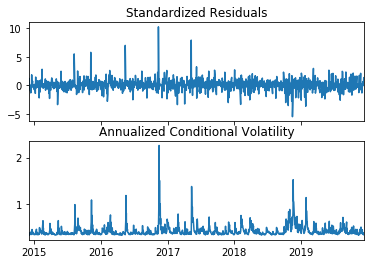

In [37]:
figure_nvda = final_nvda.plot(annualize='D')

In [38]:
# Forecasting from GARCH
last_day = df.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-12'

In [39]:
forecast_horizon = 10
forecasts_nvda = final_nvda.forecast(start=last_day, horizon=forecast_horizon)

# Annualize the forecast
intermediate = np.sqrt(forecasts_nvda.variance.dropna() * 252)
intermediate.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2019-12-12,0.375186,0.425446,0.405313,0.434569,0.423744,0.441148,0.435343,0.445843,0.442766,0.449166


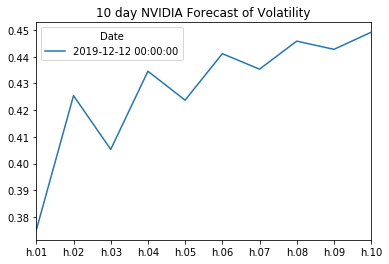

In [42]:
# Plot the forecast
final_nvda_plot = intermediate.dropna().T
final_nvda_plot.plot(title = '10 day NVIDIA Forecast of Volatility')

# Time Series Linear Regression

In [43]:
# Price Prediction 
df_1 = stocks_df.copy()
df_1['Return_nvda'] = df_1['NVDA_Close'].pct_change() * 100
df_1['Lagged_return_nvda'] = df_1.Return_nvda.shift()
df_1 = df_1.dropna()
df_1.head()

y = df_1['Return_nvda']
X = df_1['Lagged_return_nvda'].to_frame()
X['Week_of_year'] = X.index.weekofyear
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_year'])

model_linear = LinearRegression()
model_linear.fit(X_binary_encoded, y)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
predictions = model_linear.predict(X_binary_encoded)

r2 = r2_score(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {np.std(y)}")

R-squared (R2 ): 0.03719027874706937
Mean Squared Error (MSE): 6.944117311256448
Root Mean Squared Error (RMSE): 2.6351693135843184
Standard Deviation of Futures Return: 2.6855812196894795


# Train Test Split Prediction

Out-of-sample Root Mean Squared Error (RMSE): 2.6031251084665596


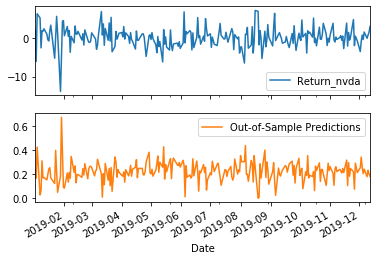

In [44]:
# Train Test Split Predictions
train = df_1.loc['2014':'2019']
test = df_1['2019']

# Create train and test sets for dependent and independent variables
X_train = train["Lagged_return_nvda"].to_frame()
y_train = train["Return_nvda"]
X_test = test["Lagged_return_nvda"].to_frame()
y_test = test["Return_nvda"]


model_baba = LinearRegression()
model_baba.fit(X_train, y_train)
predictions = model_baba.predict(X_test)

out_of_sample_results = y_test.to_frame()
out_of_sample_results["Out-of-Sample Predictions"] = model_baba.predict(X_test)

# Plot the out-of-sample results for 2019
out_of_sample_results.plot(subplots=True)

# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(out_of_sample_results["Return_nvda"], out_of_sample_results["Out-of-Sample Predictions"])

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

# Deep Learning